<a href="https://colab.research.google.com/github/brothersanta/UT-AI/blob/main/Unsupervised_Learning_CreditCardCustomerSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

### Context


AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help


### Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.


###  Data Description

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

**Data Dictionary**

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of Visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

## Importing necessary libraries and data

In [ ]:
## IMPORT NECESSARY LIBRARIES AND DATA
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
from tqdm import tqdm

# Libraries to help with data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

# to compute distances
from scipy.spatial.distance import pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

# to perform PCA
from sklearn.decomposition import PCA

# to suppress warnings
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# import problem set data
from google.colab import files
uploaded = files.upload()


Saving Credit+Card+Customer+Data.xlsx to Credit+Card+Customer+Data (4).xlsx


In [ ]:
# Confirm data was uploaded successfully

df=pd.read_excel('Credit+Card+Customer+Data.xlsx')
print(df)

     Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0        1         87073            100000                   2   
1        2         38414             50000                   3   
2        3         17341             50000                   7   
3        4         40496             30000                   5   
4        5         47437            100000                   6   
..     ...           ...               ...                 ...   
655    656         51108             99000                  10   
656    657         60732             84000                  10   
657    658         53834            145000                   8   
658    659         80655            172000                  10   
659    660         80150            167000                   9   

     Total_visits_bank  Total_visits_online  Total_calls_made  
0                    1                    1                 0  
1                    0                   10                 9  
2              

## Data Overview

- Observations
- Sanity checks

In [ ]:
# confirm the number of rows and columns
df.shape

(660, 7)

In [ ]:
#OBSERVATIONS: data set has 660 rows and 7 columns

In [ ]:
# examine data quality and structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [ ]:
#OBSERVATIONS: data is all integers with no null values

In [ ]:
# examine data for potential scaling issues
df.describe()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,330.500000,55141.443939,34574.242424,4.706061,2.403030,2.606061,3.583333
std,190.669872,25627.772200,37625.487804,2.167835,1.631813,2.935724,2.865317
min,1.000000,11265.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,165.750000,33825.250000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,330.500000,53874.500000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,495.250000,77202.500000,48000.000000,6.000000,4.000000,4.000000,5.000000
max,660.000000,99843.000000,200000.000000,10.000000,5.000000,15.000000,10.000000


In [ ]:
### OBSERVATIONS: columns "S1_NO" and "Customer Key" will probably not be meaningful to analysis and can be dropped; column 'Avg_Credit_Limit' will require the data to be scaled

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

### Questions

1. How is the distrubution of average credit limit of customer?
2. What percenatage of the customers have never made a service-related call to the bank?
3. What percentage of customers have never logged in to the online portal?
4. How many customers have never visited bank?
3. How are the different variables correlated with each other?

In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="gold"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

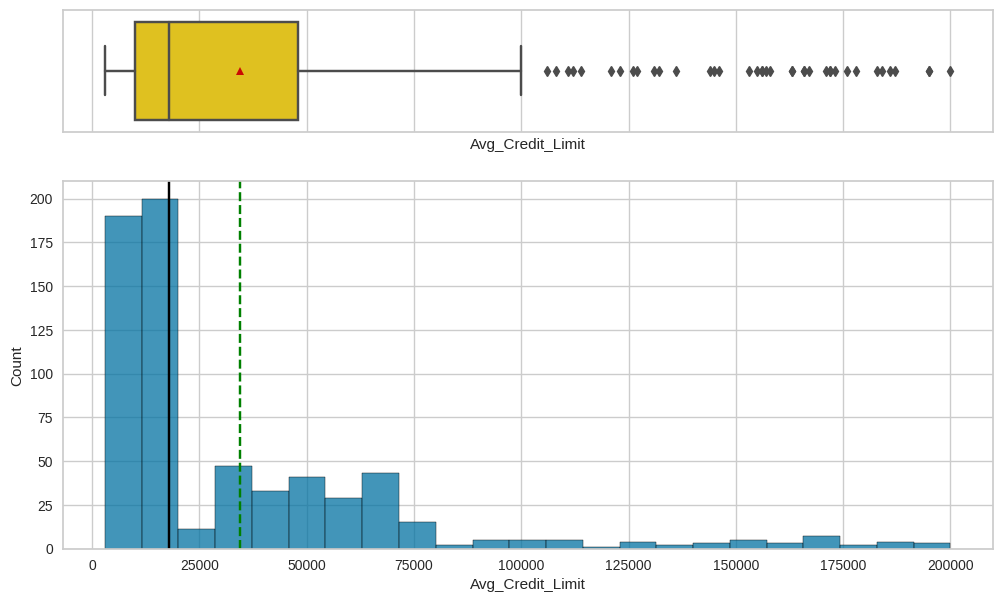

In [ ]:
histogram_boxplot(df, "Avg_Credit_Limit")

In [ ]:
#How is the distrubution of average credit limit of customer?
## Distribution is positively skewed to the right of the mean
## The at below $25000 for Avg Credit Limit.
## There are outliers beyond $100000 Avg Credit Limit

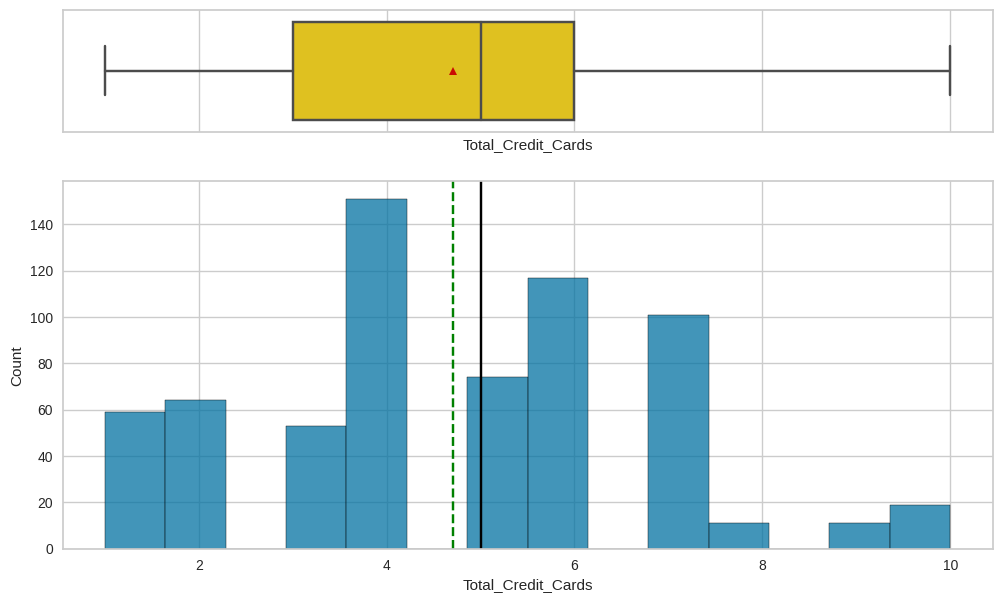

In [ ]:
histogram_boxplot(df, "Total_Credit_Cards")

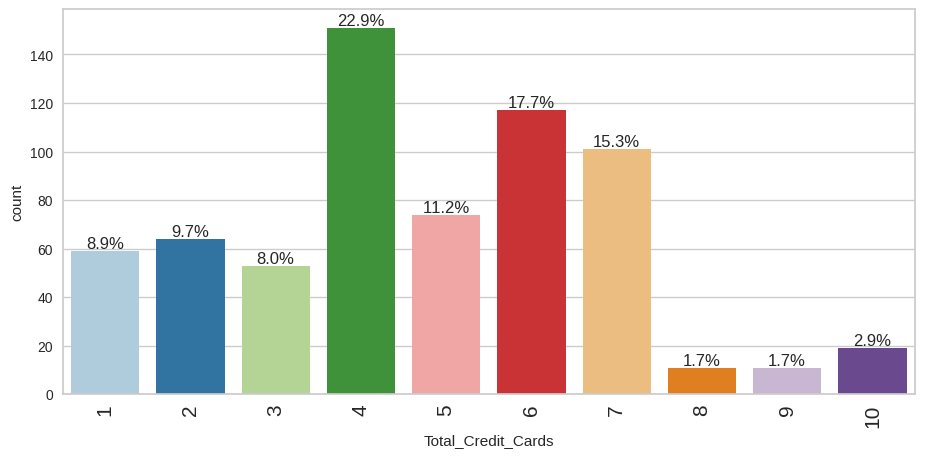

In [ ]:
labeled_barplot(df, "Total_Credit_Cards", perc=True)

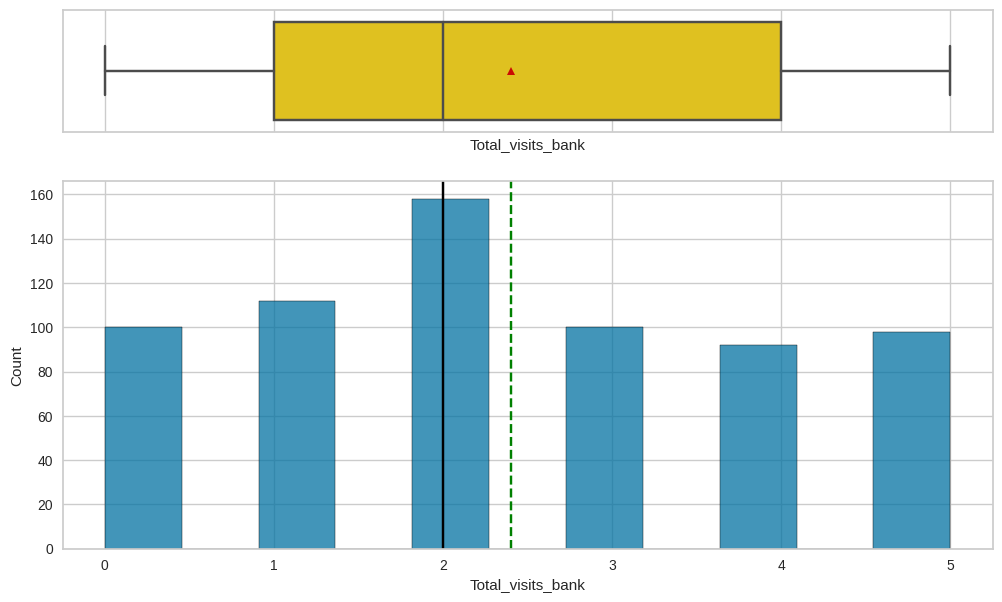

In [ ]:
histogram_boxplot(df, "Total_visits_bank")

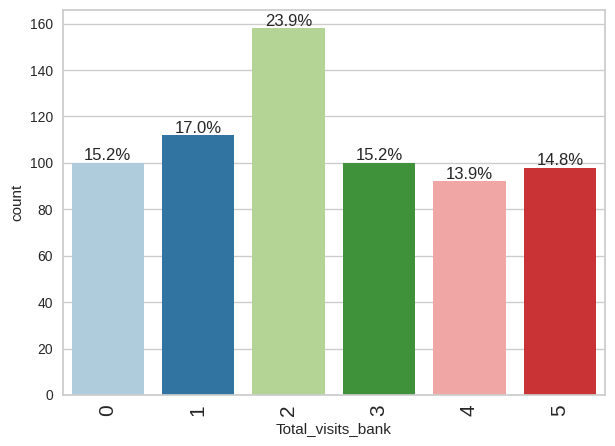

In [ ]:
labeled_barplot(df, "Total_visits_bank", perc=True)

In [ ]:
#OBSERVATION: 15.2% of customers have never visited a bank

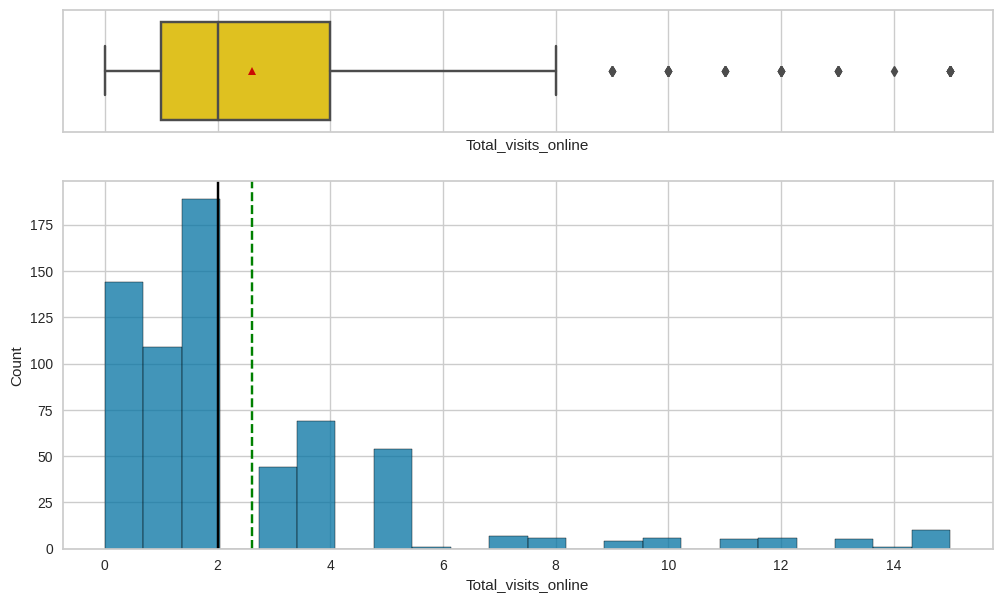

In [ ]:
histogram_boxplot(df, "Total_visits_online")

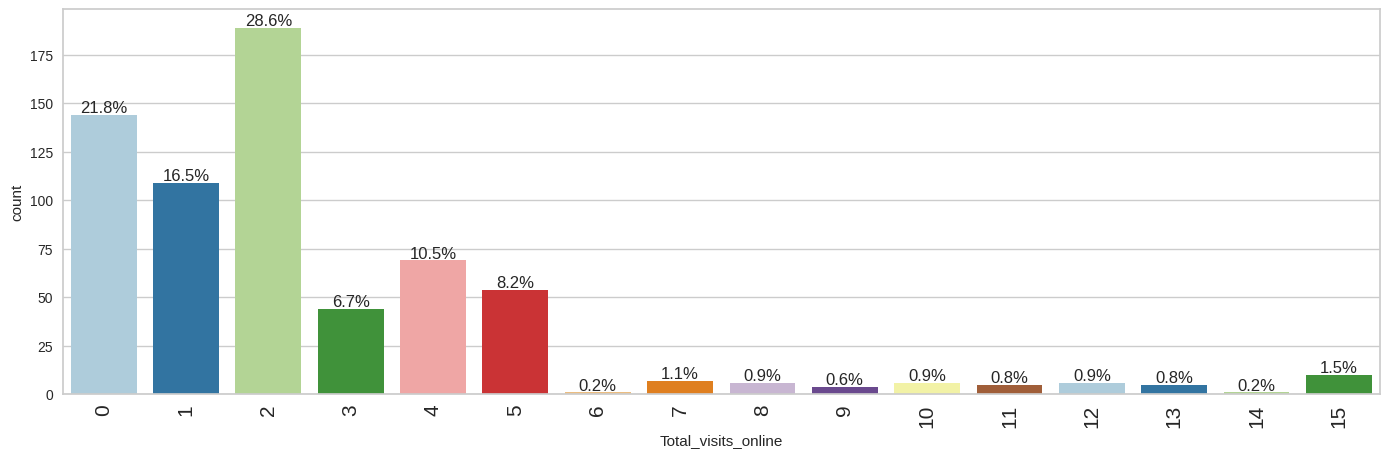

In [ ]:
labeled_barplot(df, "Total_visits_online", perc=True)

In [ ]:
# OBSERVATION: The percentage of customers who have never logged into the online portal is 22.7%

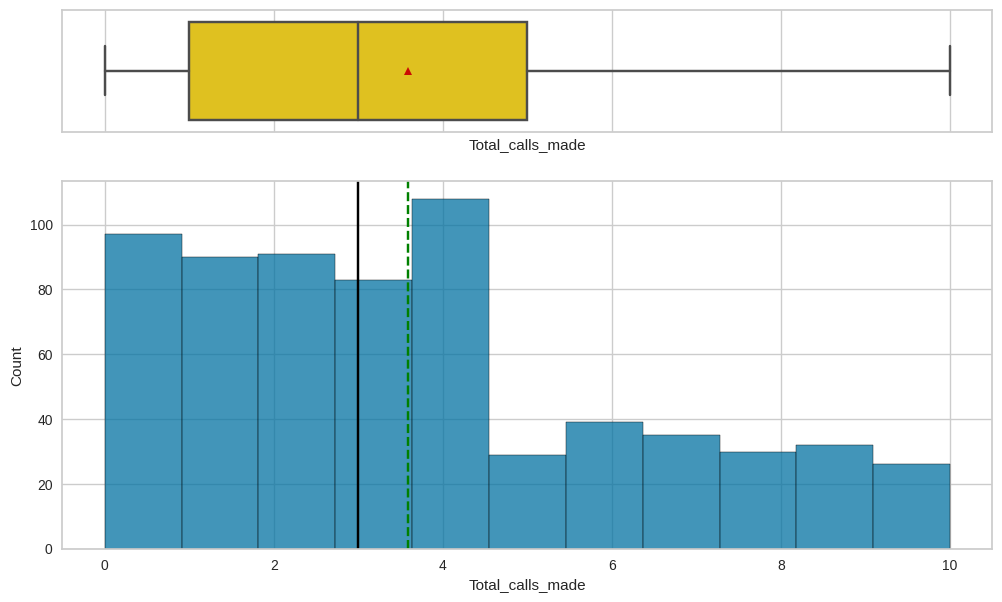

In [ ]:
histogram_boxplot(df, "Total_calls_made")

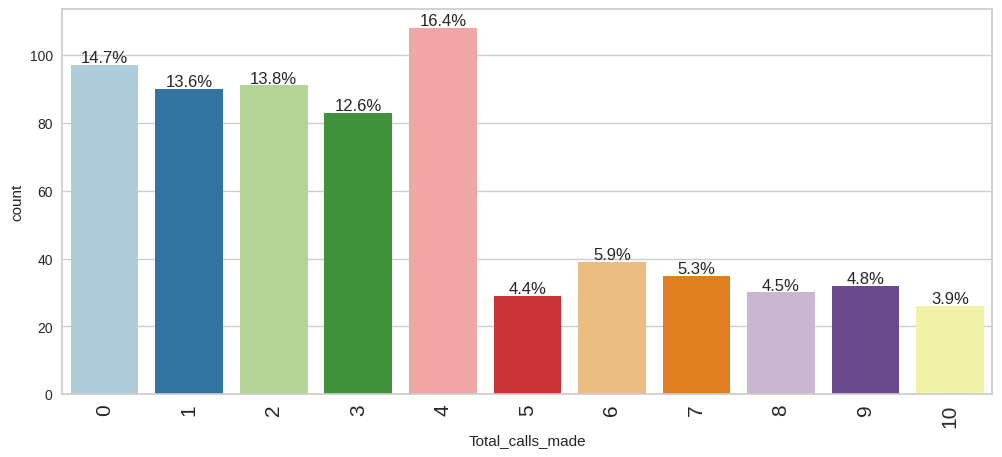

In [ ]:
labeled_barplot(df, "Total_calls_made", perc=True)

In [ ]:
#OBSERVATION: The percentage of customers who have never never made a service-related call to the bank is 13.6969%

## Data Preprocessing



- Duplicate value check
- Missing value treatment
- Outlier check
- Feature engineering (if needed)
- Any other preprocessing steps (if needed)

In [ ]:
# normalize column names
df.columns = [c.replace(" ", "_") for c in df.columns]

In [ ]:
df.head()

,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [ ]:
df.isnull().sum()

Sl_No                  0
Customer_Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [ ]:
# getting the count for each unique value in Customer_Key
data_grouped = df.groupby("Customer_Key").count()


In [ ]:
# find the duplicates in the dataframe
for i in data_grouped.loc[data_grouped.Sl_No >= 2].index:
    display(df.loc[df.Customer_Key == i])

,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,6000,4,0,2,8
432,433,37252,59000,6,2,1,2


,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
4,5,47437,100000,6,0,12,3
332,333,47437,17000,7,3,1,0


,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
411,412,50706,44000,4,5,0,2
541,542,50706,60000,7,5,2,2


,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2


,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
104,105,97935,17000,2,1,2,10
632,633,97935,187000,7,1,7,0


In [ ]:
#drop the rows with duplicate Customer_Key
df.drop([48, 432, 4, 332, 411, 541, 391, 398, 104, 632], inplace=True)

In [ ]:
# find outliers in the data using a z-score with a threshold of 3

threshold = 3
outlier = {}
for col in df.columns:
    i = df[col]
    mean = np.mean(df[col])
    std = np.std(df[col])
    list1 = []
    for v in i:
        z = (v - mean) / std
        if z > threshold:
            list1.append(v)
    list1.sort()
    outlier[i.name] = list1

print("The following are the outliers in the data:")
for key, value in outlier.items():
    print("\n", key, ":", value)

The following are the outliers in the data:

 Sl_No : []

 Customer_Key : []

 Avg_Credit_Limit : [146000, 153000, 155000, 156000, 156000, 157000, 158000, 163000, 163000, 166000, 166000, 167000, 171000, 172000, 172000, 173000, 176000, 178000, 183000, 184000, 186000, 195000, 195000, 200000]

 Total_Credit_Cards : []

 Total_visits_bank : []

 Total_visits_online : [12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]

 Total_calls_made : []


In [ ]:
# drop the rows with outliers


In [ ]:
df.value_counts('Avg_Credit_Limit')

Avg_Credit_Limit
8000      35
6000      30
9000      28
13000     27
10000     26
19000     26
7000      24
11000     24
18000     23
14000     23
16000     22
17000     21
5000      21
20000     20
12000     18
15000     17
36000     11
70000     10
50000      8
38000      8
68000      7
39000      7
56000      7
41000      6
37000      6
34000      6
48000      6
52000      6
30000      6
47000      6
74000      6
31000      5
29000      5
26000      5
65000      5
51000      4
49000      4
54000      4
71000      4
64000      4
66000      4
69000      4
33000      4
73000      4
60000      4
62000      3
59000      3
72000      3
61000      3
46000      3
58000      3
45000      3
57000      3
40000      3
28000      3
63000      2
32000      2
100000     2
84000      2
44000      2
27000      2
75000      2
35000      2
42000      2
67000      2
132000     1
108000     1
144000     1
131000     1
127000     1
126000     1
123000     1
121000     1
114000     1
112000     1
136000  

In [ ]:
df.value_counts('Total_visits_online')

Total_visits_online
2     185
0     142
1     107
4      69
5      54
3      44
15      5
8       4
10      4
11      3
13      3
7       2
9       2
6       1
12      1
dtype: int64

In [ ]:
#drop the columns with unnecessary keys
df.drop(columns = ['Sl_No', 'Customer_Key'], inplace=True)

## EDA

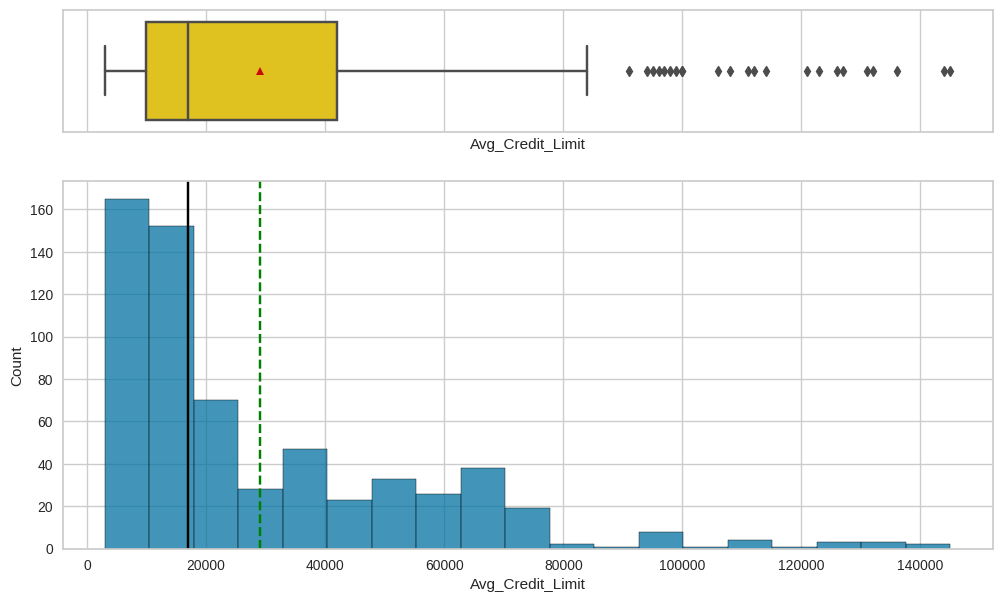

In [ ]:
histogram_boxplot(df, "Avg_Credit_Limit")

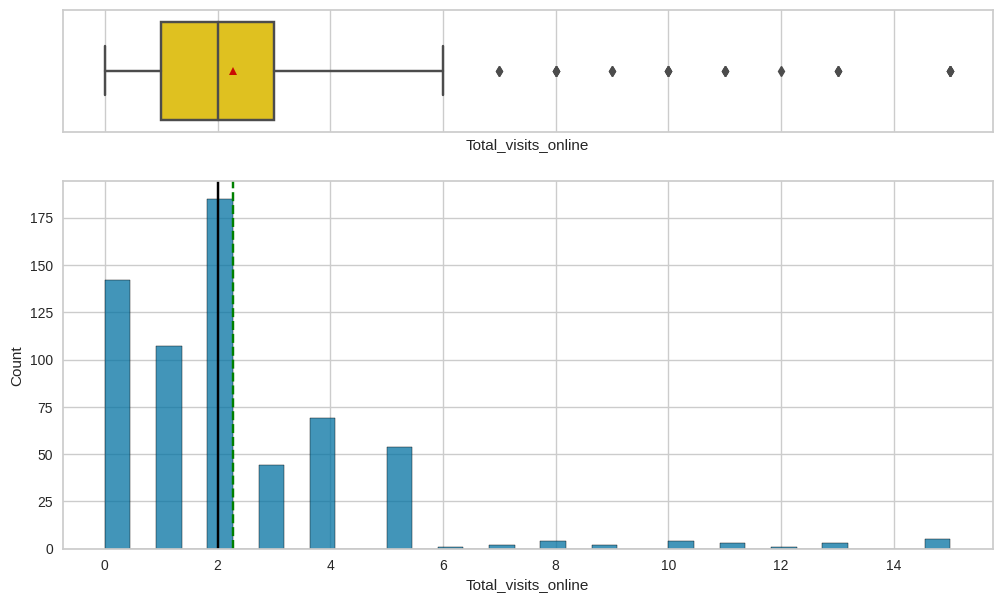

In [ ]:
histogram_boxplot(df, "Total_visits_online")

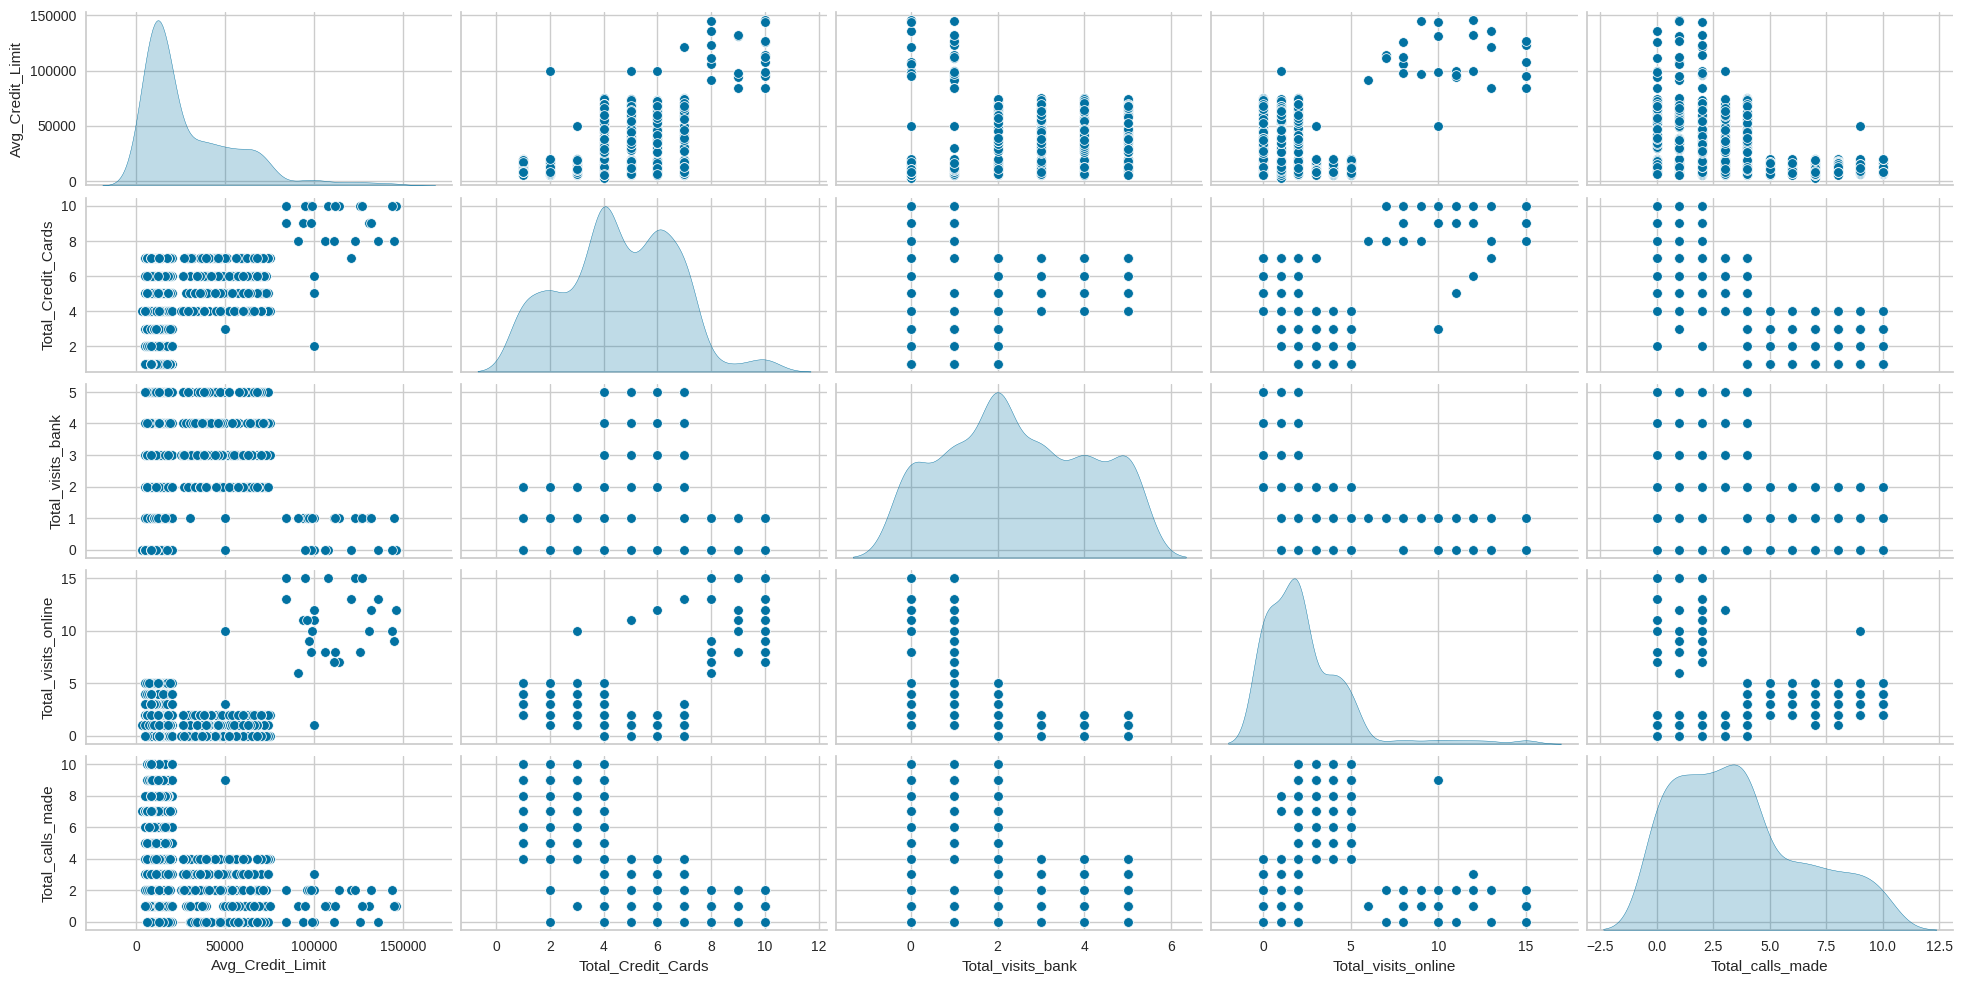

In [ ]:
# check for correlations
sns.pairplot(df, height=2,aspect=2 , diag_kind='kde')

- It is a good idea to explore the data once again after manipulating it.

In [ ]:
#OBSERVATIONS
## potential positive correlation between number of credit cards and avg credit limit
## potential inverse correlation between avg credit limit and total bank visits
## potential positive correlation between avg credit limit and total online visits
## potential inverse correlation between avg credit and calls made
## potential inverse correlation between bank visits and online visits
## potential inverse correlation between bank visits and calls made
## potential inverse correlation between between online visits and calls made

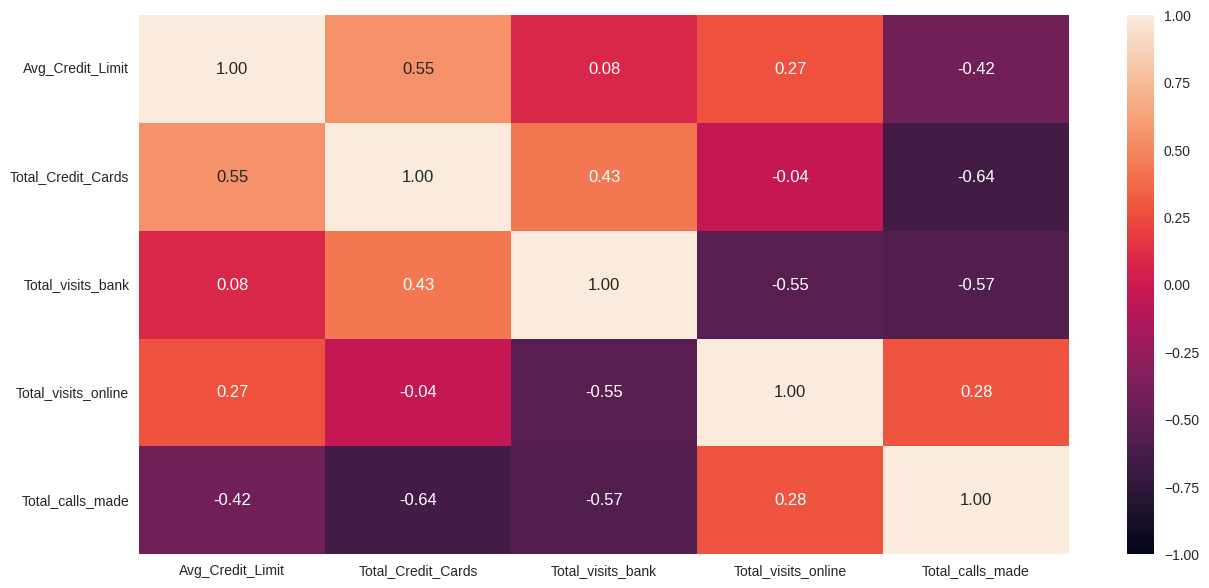

In [ ]:
## check for correlation
col_list = ['Avg_Credit_Limit','Total_Credit_Cards','Total_visits_bank','Total_visits_online','Total_calls_made']
plt.figure(figsize=(15,7))
sns.heatmap(df[col_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f")
plt.show()

In [ ]:
##OBSERVATIONS
# overall, correlations are weak; the most notable relationships are:
# avg credit limit vs total credit cards .61
# total credit cards vs calls made -.65
# bank visits vs online visits -.55


In [ ]:
# Scale the data before clustering
scaler = StandardScaler()
ScaledData = scaler.fit_transform(df)

#check scaling was successful
print(ScaledData)

[[ 2.69699841 -1.23947549 -0.91483359 -0.53540024 -1.29314513]
 [ 0.79753281 -0.7520938  -1.53529495  3.24460595  1.85669475]
 [ 0.79753281  1.19743298 -0.91483359  0.30460114  0.10678371]
 ...
 [ 2.65900909  2.65957806 -0.91483359  3.24460595 -1.29314513]
 [ 2.08916942  2.65957806 -0.91483359  4.50460801 -0.59318071]
 [ 4.40651745  1.68481468 -0.91483359  2.82460526 -0.94316292]]


In [ ]:
# creating a dataframe of the scaled data
ScaledDf = pd.DataFrame(ScaledData, columns=df.columns)

In [ ]:
print(ScaledDf)

     Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0            2.696998           -1.239475          -0.914834   
1            0.797533           -0.752094          -1.535295   
2            0.797533            1.197433          -0.914834   
3            0.037747            0.222670          -0.914834   
4           -0.342147           -0.752094          -1.535295   
..                ...                 ...                ...   
621          3.912656            2.172196          -0.914834   
622          2.507052            2.659578          -1.535295   
623          2.659009            2.659578          -0.914834   
624          2.089169            2.659578          -0.914834   
625          4.406517            1.684815          -0.914834   

     Total_visits_online  Total_calls_made  
0              -0.535400         -1.293145  
1               3.244606          1.856695  
2               0.304601          0.106784  
3              -0.535400          0.106784  
4     

## K-means Clustering

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

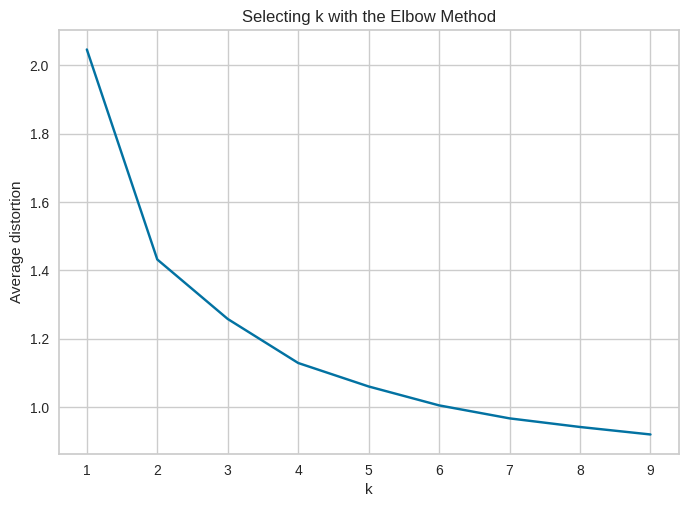

In [ ]:
#Finding optimal no. of clusters
from scipy.spatial.distance import cdist
clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(ScaledDf)
    prediction=model.predict(ScaledDf)
    meanDistortions.append(sum(np.min(cdist(ScaledDf, model.cluster_centers_, 'euclidean'), axis=1)) / ScaledDf.shape[0])


plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')


In [ ]:
# Explore values for K starting with 3
final_model=KMeans(3)
final_model.fit(ScaledDf)
prediction=final_model.predict(ScaledDf)

#Append the prediction
df["GROUP"] = prediction
ScaledDf["GROUP"] = prediction
print("Groups Assigned : \n")
df.head()

Groups Assigned : 



,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP
0,100000,2,1,1,0,0
1,50000,3,0,10,9,1
2,50000,7,1,3,4,0
3,30000,5,1,1,4,0
5,20000,3,0,1,8,1


In [ ]:
ScaledDf.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP
0,2.696998,-1.239475,-0.914834,-0.535400,-1.293145,0
1,0.797533,-0.752094,-1.535295,3.244606,1.856695,1
2,0.797533,1.197433,-0.914834,0.304601,0.106784,0
3,0.037747,0.222670,-0.914834,-0.535400,0.106784,0
4,-0.342147,-0.752094,-1.535295,-0.535400,1.506713,1


array([[<Axes: title={'center': 'Avg_Credit_Limit'}, xlabel='[GROUP]'>,
        <Axes: title={'center': 'Total_Credit_Cards'}, xlabel='[GROUP]'>,
        <Axes: title={'center': 'Total_calls_made'}, xlabel='[GROUP]'>,
        <Axes: title={'center': 'Total_visits_bank'}, xlabel='[GROUP]'>],
       [<Axes: title={'center': 'Total_visits_online'}, xlabel='[GROUP]'>,
        <Axes: >, <Axes: >, <Axes: >]], dtype=object)

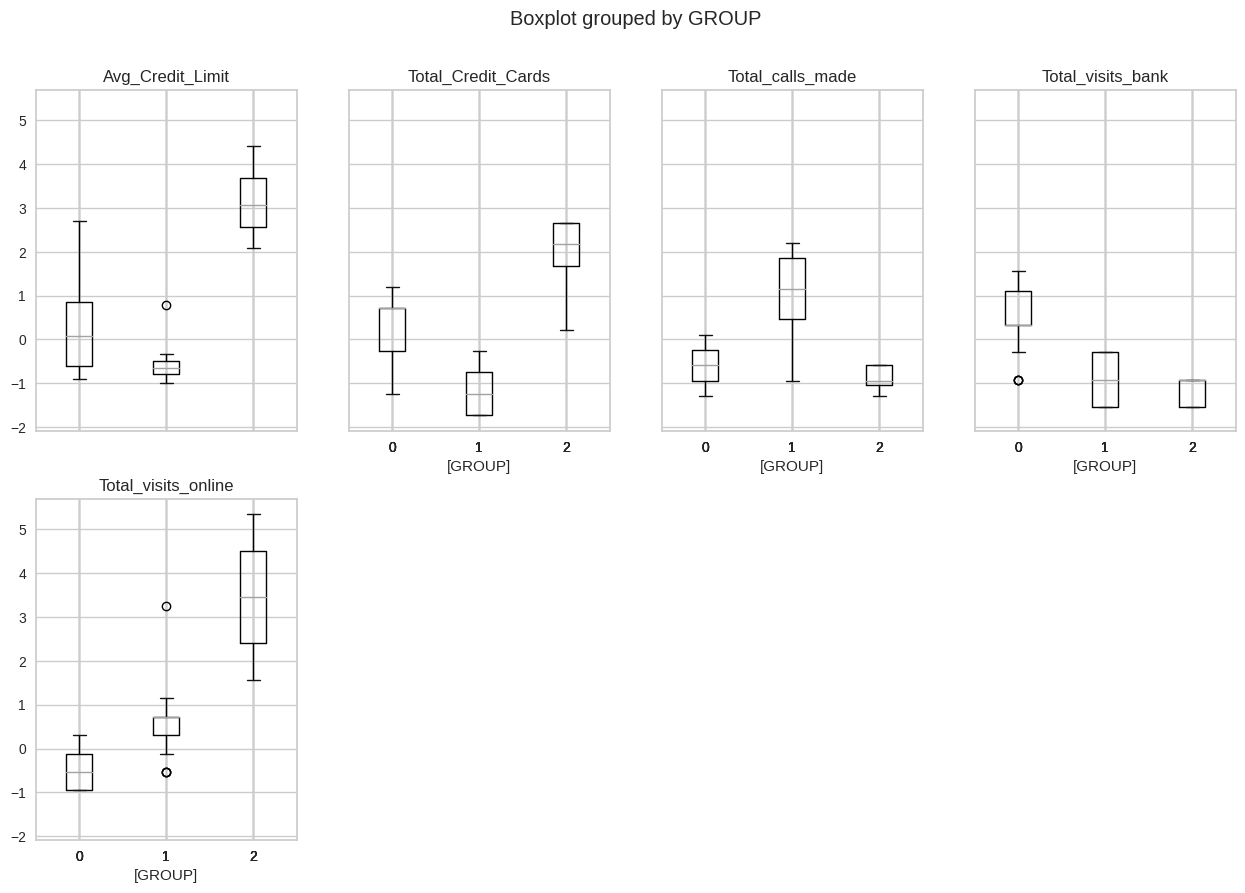

In [ ]:
ScaledDf.boxplot(by='GROUP', layout = (2,4),figsize=(15,10))

In [ ]:
# Explore values for K now with 4
final_model=KMeans(4)
final_model.fit(ScaledDf)
prediction=final_model.predict(ScaledDf)

#Append the prediction
df["GROUP"] = prediction
ScaledDf["GROUP"] = prediction
print("Groups Assigned : \n")
df.head()

Groups Assigned : 



,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP
0,100000,2,1,1,0,0
1,50000,3,0,10,9,1
2,50000,7,1,3,4,0
3,30000,5,1,1,4,3
5,20000,3,0,1,8,1


In [ ]:
ScaledDf.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP
0,2.696998,-1.239475,-0.914834,-0.535400,-1.293145,0
1,0.797533,-0.752094,-1.535295,3.244606,1.856695,1
2,0.797533,1.197433,-0.914834,0.304601,0.106784,0
3,0.037747,0.222670,-0.914834,-0.535400,0.106784,3
4,-0.342147,-0.752094,-1.535295,-0.535400,1.506713,1


array([[<Axes: title={'center': 'Avg_Credit_Limit'}, xlabel='[GROUP]'>,
        <Axes: title={'center': 'Total_Credit_Cards'}, xlabel='[GROUP]'>,
        <Axes: title={'center': 'Total_calls_made'}, xlabel='[GROUP]'>,
        <Axes: title={'center': 'Total_visits_bank'}, xlabel='[GROUP]'>],
       [<Axes: title={'center': 'Total_visits_online'}, xlabel='[GROUP]'>,
        <Axes: >, <Axes: >, <Axes: >]], dtype=object)

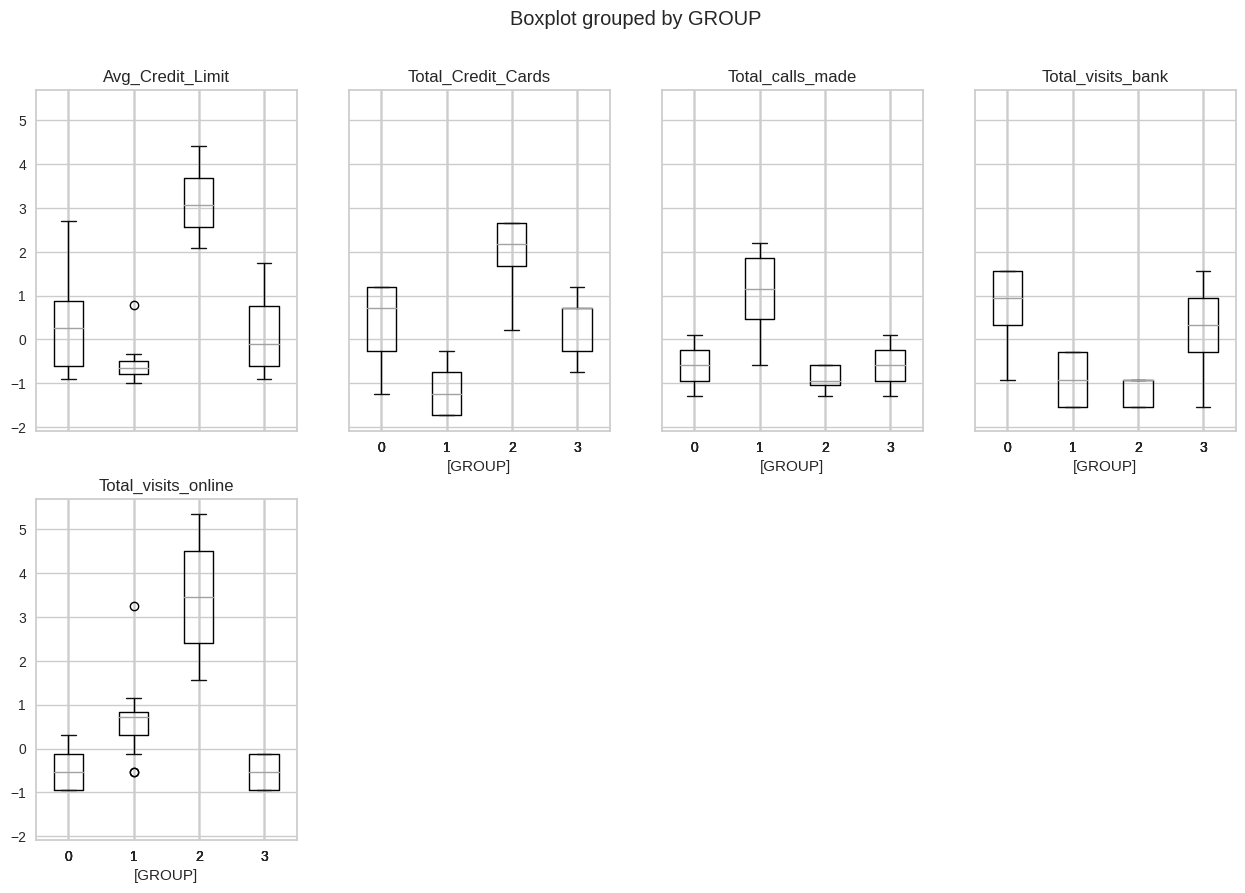

In [ ]:
ScaledDf.boxplot(by='GROUP', layout = (2,4),figsize=(15,10))

In [ ]:
# Explore values for K now with 5
final_model=KMeans(5)
final_model.fit(ScaledDf)
prediction=final_model.predict(ScaledDf)

#Append the prediction
df["GROUP"] = prediction
ScaledDf["GROUP"] = prediction
print("Groups Assigned : \n")
df.head()

Groups Assigned : 



,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP
0,100000,2,1,1,0,4
1,50000,3,0,10,9,0
2,50000,7,1,3,4,4
3,30000,5,1,1,4,2
5,20000,3,0,1,8,0


In [ ]:
ScaledDf.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP
0,2.696998,-1.239475,-0.914834,-0.535400,-1.293145,4
1,0.797533,-0.752094,-1.535295,3.244606,1.856695,0
2,0.797533,1.197433,-0.914834,0.304601,0.106784,4
3,0.037747,0.222670,-0.914834,-0.535400,0.106784,2
4,-0.342147,-0.752094,-1.535295,-0.535400,1.506713,0


array([[<Axes: title={'center': 'Avg_Credit_Limit'}, xlabel='[GROUP]'>,
        <Axes: title={'center': 'Total_Credit_Cards'}, xlabel='[GROUP]'>,
        <Axes: title={'center': 'Total_calls_made'}, xlabel='[GROUP]'>,
        <Axes: title={'center': 'Total_visits_bank'}, xlabel='[GROUP]'>],
       [<Axes: title={'center': 'Total_visits_online'}, xlabel='[GROUP]'>,
        <Axes: >, <Axes: >, <Axes: >]], dtype=object)

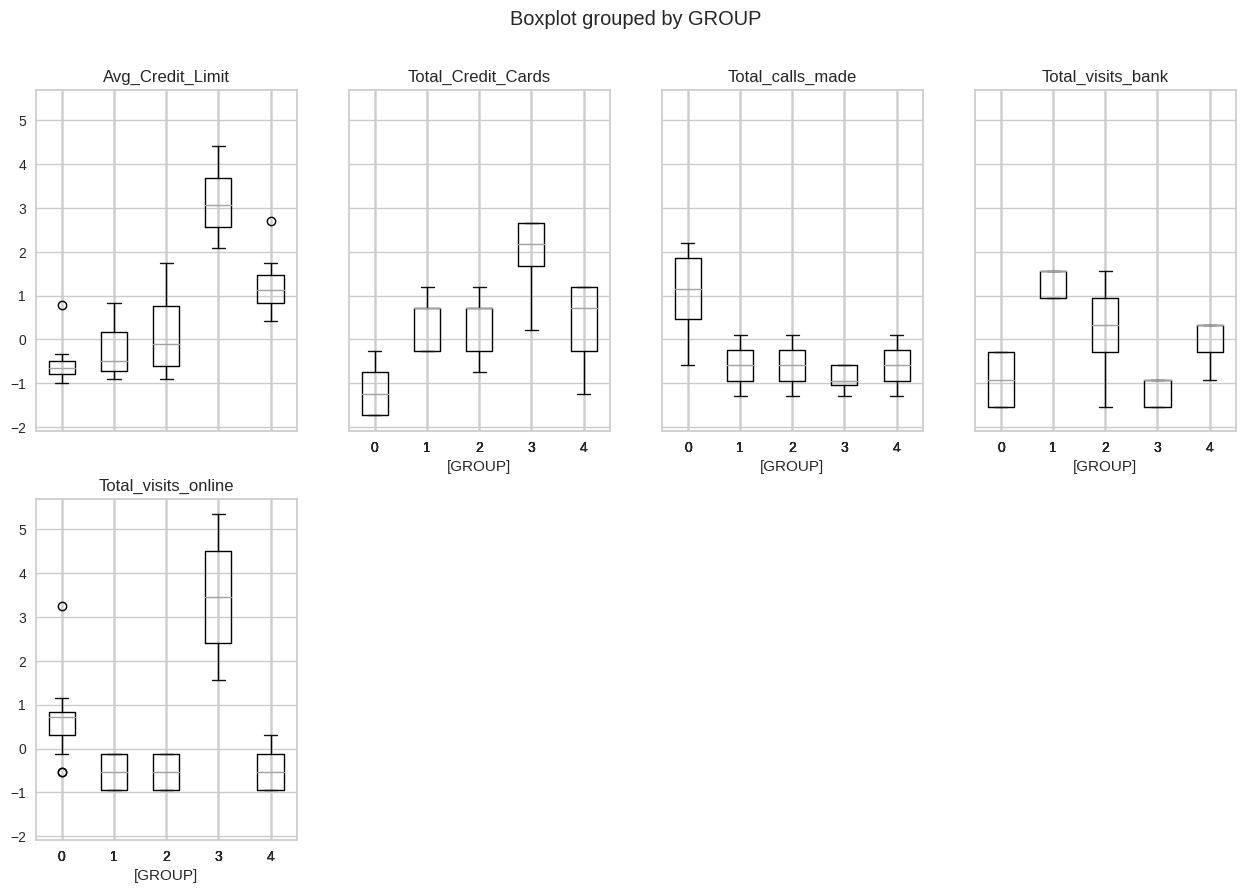

In [ ]:
ScaledDf.boxplot(by='GROUP', layout = (2,4),figsize=(15,10))

In [ ]:
# Explore values for K now with 6
final_model=KMeans(6)
final_model.fit(ScaledDf)
prediction=final_model.predict(ScaledDf)

#Append the prediction
df["GROUP"] = prediction
ScaledDf["GROUP"] = prediction
print("Groups Assigned : \n")
df.head()

Groups Assigned : 



,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP
0,100000,2,1,1,0,2
1,50000,3,0,10,9,1
2,50000,7,1,3,4,2
3,30000,5,1,1,4,4
5,20000,3,0,1,8,1


array([[<Axes: title={'center': 'Avg_Credit_Limit'}, xlabel='[GROUP]'>,
        <Axes: title={'center': 'K_means_segments'}, xlabel='[GROUP]'>,
        <Axes: title={'center': 'Total_Credit_Cards'}, xlabel='[GROUP]'>,
        <Axes: title={'center': 'Total_calls_made'}, xlabel='[GROUP]'>],
       [<Axes: title={'center': 'Total_visits_bank'}, xlabel='[GROUP]'>,
        <Axes: title={'center': 'Total_visits_online'}, xlabel='[GROUP]'>,
        <Axes: >, <Axes: >]], dtype=object)

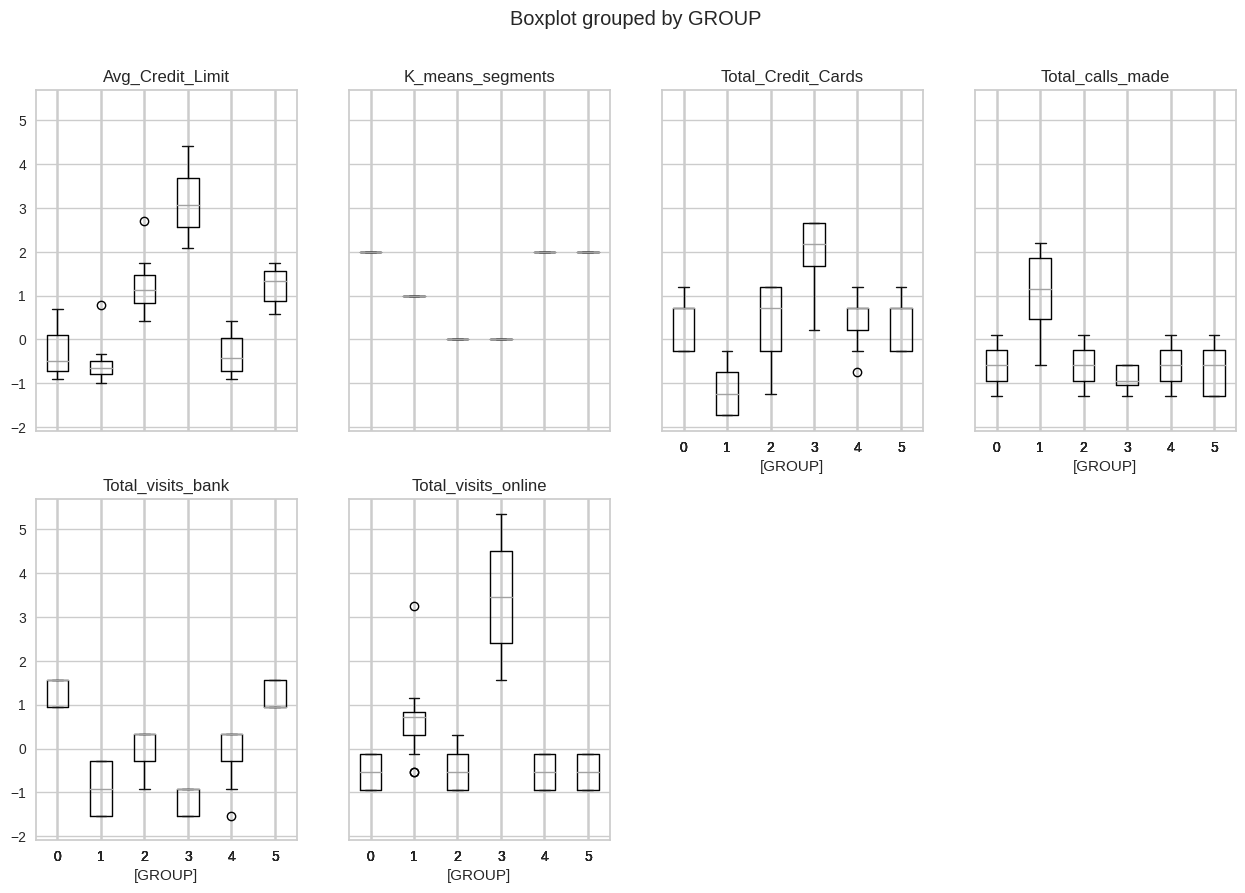

In [ ]:
ScaledDf.boxplot(by='GROUP', layout = (2,4),figsize=(15,10))

In [ ]:
# Explore values for K now with 7
final_model=KMeans(7)
final_model.fit(ScaledDf)
prediction=final_model.predict(ScaledDf)

#Append the prediction
df["GROUP"] = prediction
ScaledDf["GROUP"] = prediction
print("Groups Assigned : \n")
df.head()

Groups Assigned : 



,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP
0,100000,2,1,1,0,3
1,50000,3,0,10,9,2
2,50000,7,1,3,4,3
3,30000,5,1,1,4,0
5,20000,3,0,1,8,2


array([[<Axes: title={'center': 'Avg_Credit_Limit'}, xlabel='[GROUP]'>,
        <Axes: title={'center': 'K_means_segments'}, xlabel='[GROUP]'>,
        <Axes: title={'center': 'Total_Credit_Cards'}, xlabel='[GROUP]'>,
        <Axes: title={'center': 'Total_calls_made'}, xlabel='[GROUP]'>],
       [<Axes: title={'center': 'Total_visits_bank'}, xlabel='[GROUP]'>,
        <Axes: title={'center': 'Total_visits_online'}, xlabel='[GROUP]'>,
        <Axes: >, <Axes: >]], dtype=object)

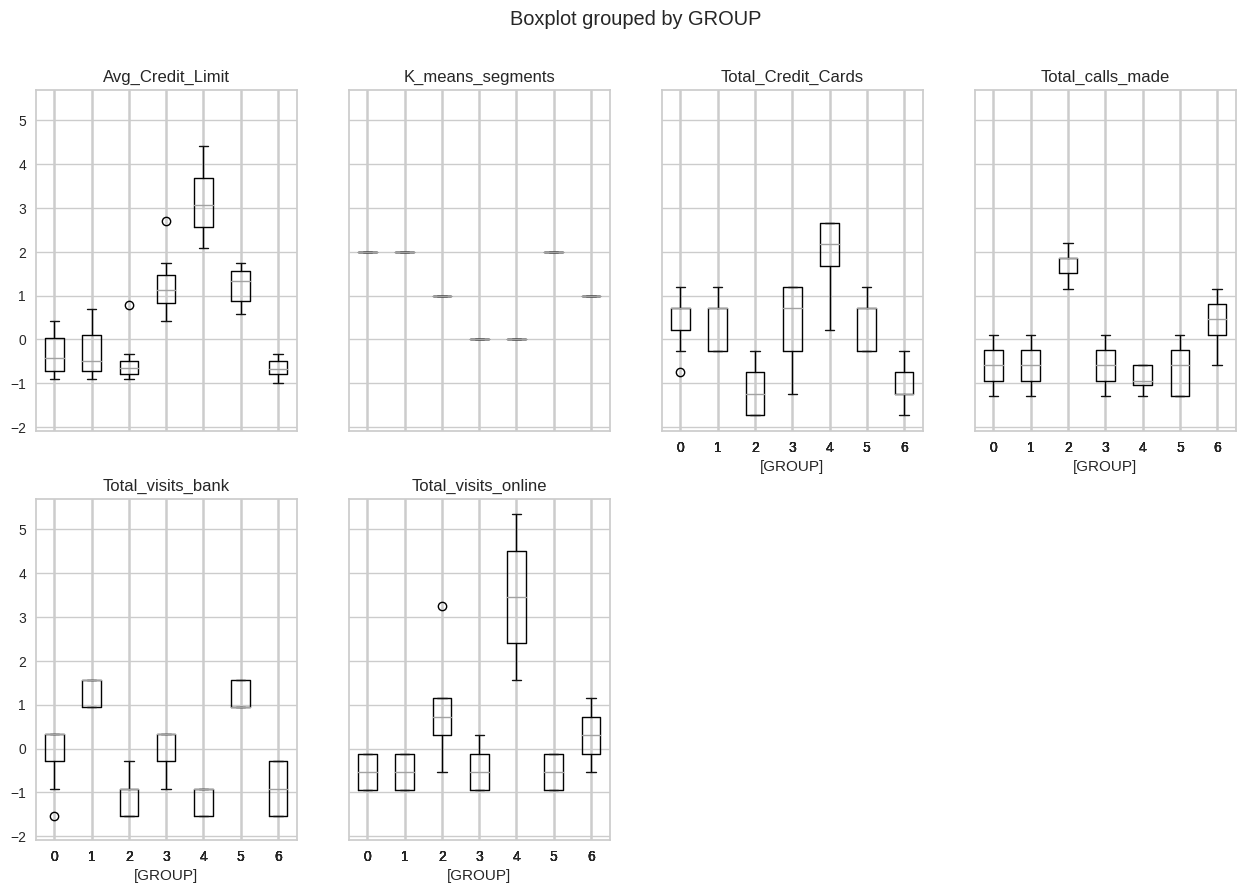

In [ ]:
ScaledDf.boxplot(by='GROUP', layout = (2,4),figsize=(15,10))

In [ ]:
sil_score = []
cluster_list = range(2, 8)
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    preds = clusterer.fit_predict((ScaledDf))
    score = silhouette_score(ScaledDf, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, the silhouette score is 0.45209956355112546)
For n_clusters = 3, the silhouette score is 0.5254016696085339)
For n_clusters = 4, the silhouette score is 0.5520967530607311)
For n_clusters = 5, the silhouette score is 0.4447727570772812)
For n_clusters = 6, the silhouette score is 0.46085147606669996)
For n_clusters = 7, the silhouette score is 0.3487662448169134)


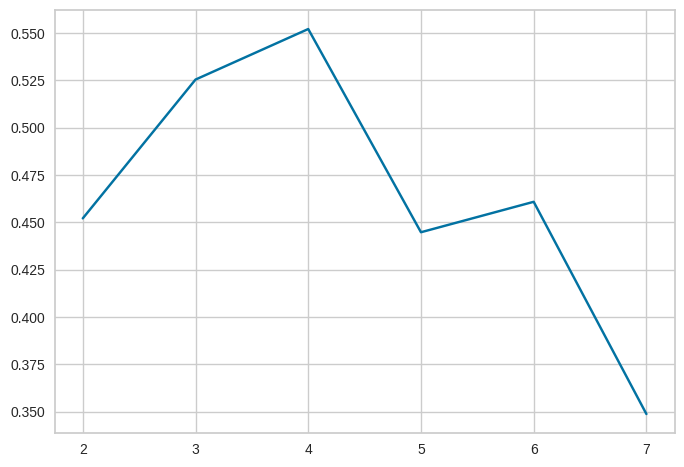

In [ ]:
plt.plot(cluster_list, sil_score)
plt.show()

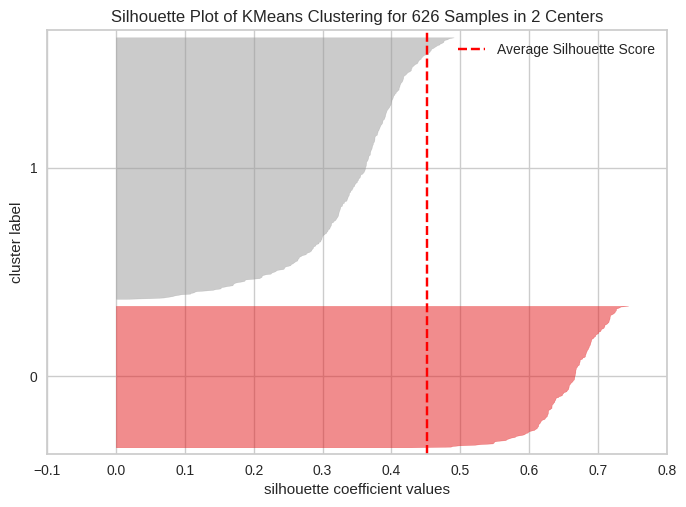

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 626 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(ScaledDf)
visualizer.show()

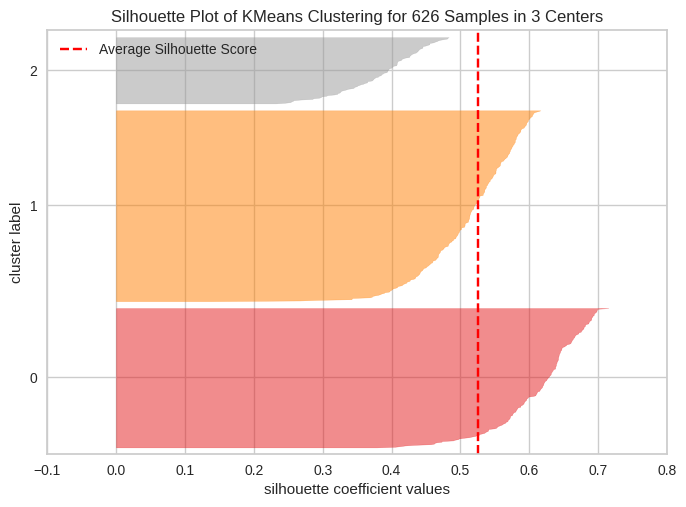

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 626 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(ScaledDf)
visualizer.show()

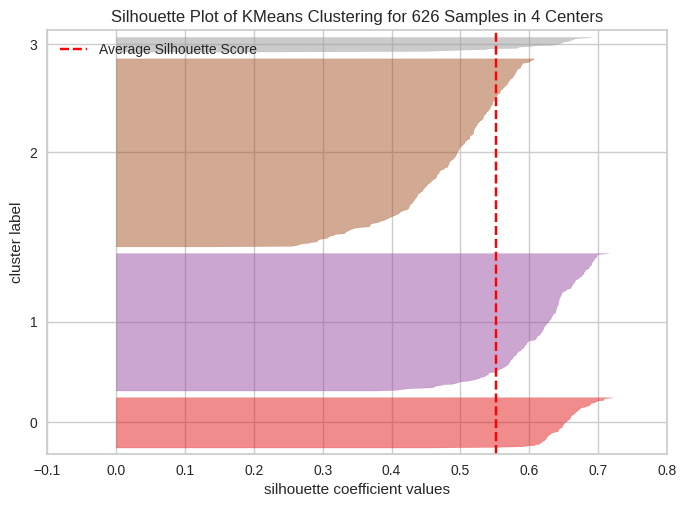

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 626 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(ScaledDf)
visualizer.show()

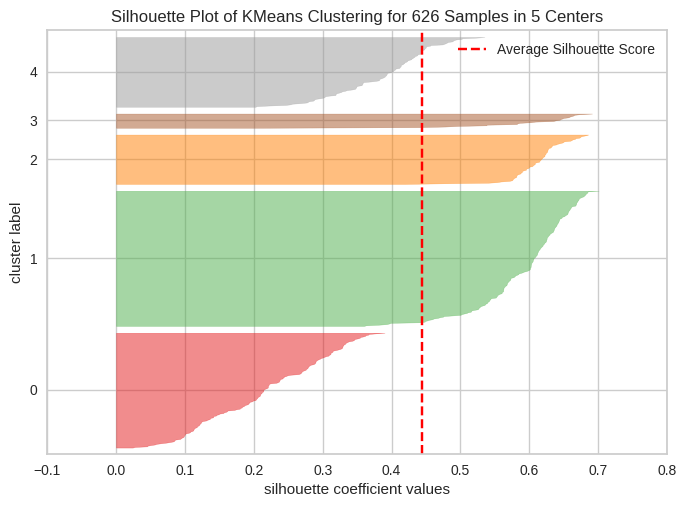

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 626 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(ScaledDf)
visualizer.show()

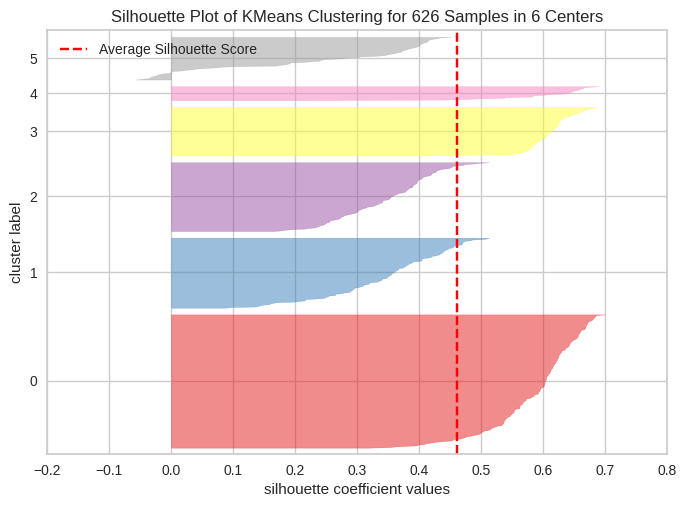

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 626 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state=1))
visualizer.fit(ScaledDf)
visualizer.show()

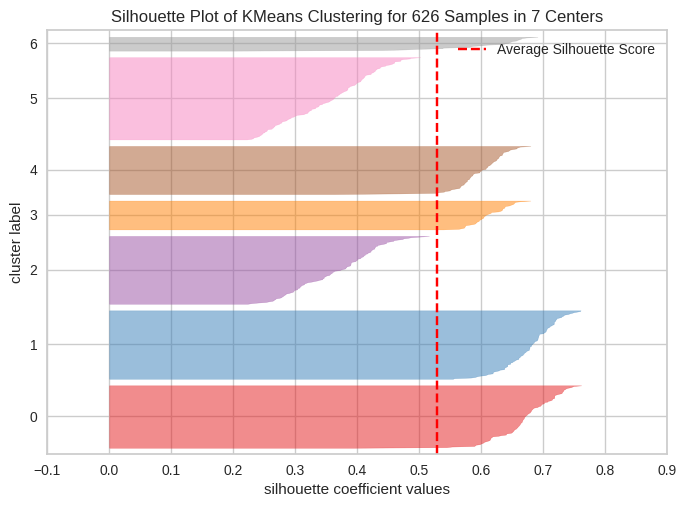

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 626 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(7, random_state=1))
visualizer.fit(ScaledDf)
visualizer.show()

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(7, random_state=1))
visualizer.fit(ScaledDf)
visualizer.show()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=1)  ## Complete the code to choose the number of clusters
kmeans.fit(ScaledDf)

KMeans(n_clusters=3, random_state=1)

In [ ]:
# creating a copy of the original data
dfK = df.copy()

# adding kmeans cluster labels to the original and scaled dataframes
ScaledDf["K_means_segments"] = kmeans.labels_
dfK["K_means_segments"] = kmeans.labels_

print(ScaledDf)
print(dfK)

     Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0            2.696998           -1.239475          -0.914834   
1            0.797533           -0.752094          -1.535295   
2            0.797533            1.197433          -0.914834   
3            0.037747            0.222670          -0.914834   
4           -0.342147           -0.752094          -1.535295   
..                ...                 ...                ...   
621          3.912656            2.172196          -0.914834   
622          2.507052            2.659578          -1.535295   
623          2.659009            2.659578          -0.914834   
624          2.089169            2.659578          -0.914834   
625          4.406517            1.684815          -0.914834   

     Total_visits_online  Total_calls_made  GROUP  K_means_segments  
0              -0.535400         -1.293145      4                 0  
1               3.244606          1.856695      0                 1  
2               0.304

## Hierarchical Clustering

In [ ]:
dfH = ScaledDf.copy()

In [ ]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0] # [distance, linkage]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(ScaledDf, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(ScaledDf))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.845103498694878.
Cophenetic correlation for Euclidean distance and complete linkage is 0.88999355285264.
Cophenetic correlation for Euclidean distance and average linkage is 0.9035038785698062.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8930151542712218.
Cophenetic correlation for Chebyshev distance and single linkage is 0.8090401572710166.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8792570208681177.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8960752536562818.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8004232499471595.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.831643058232869.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.5926053112147786.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8160480247819287.
Cophenetic correl

In [ ]:
# print the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9035038785698062, which is obtained with Euclidean distance and average linkage.


In [ ]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(ScaledDf, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(ScaledDf))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.845103498694878.
Cophenetic correlation for complete linkage is 0.88999355285264.
Cophenetic correlation for average linkage is 0.9035038785698062.
Cophenetic correlation for centroid linkage is 0.9020552054437359.
Cophenetic correlation for ward linkage is 0.7775916242144139.
Cophenetic correlation for weighted linkage is 0.8930151542712218.


In [ ]:
# print the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9035038785698062, which is obtained with average linkage.


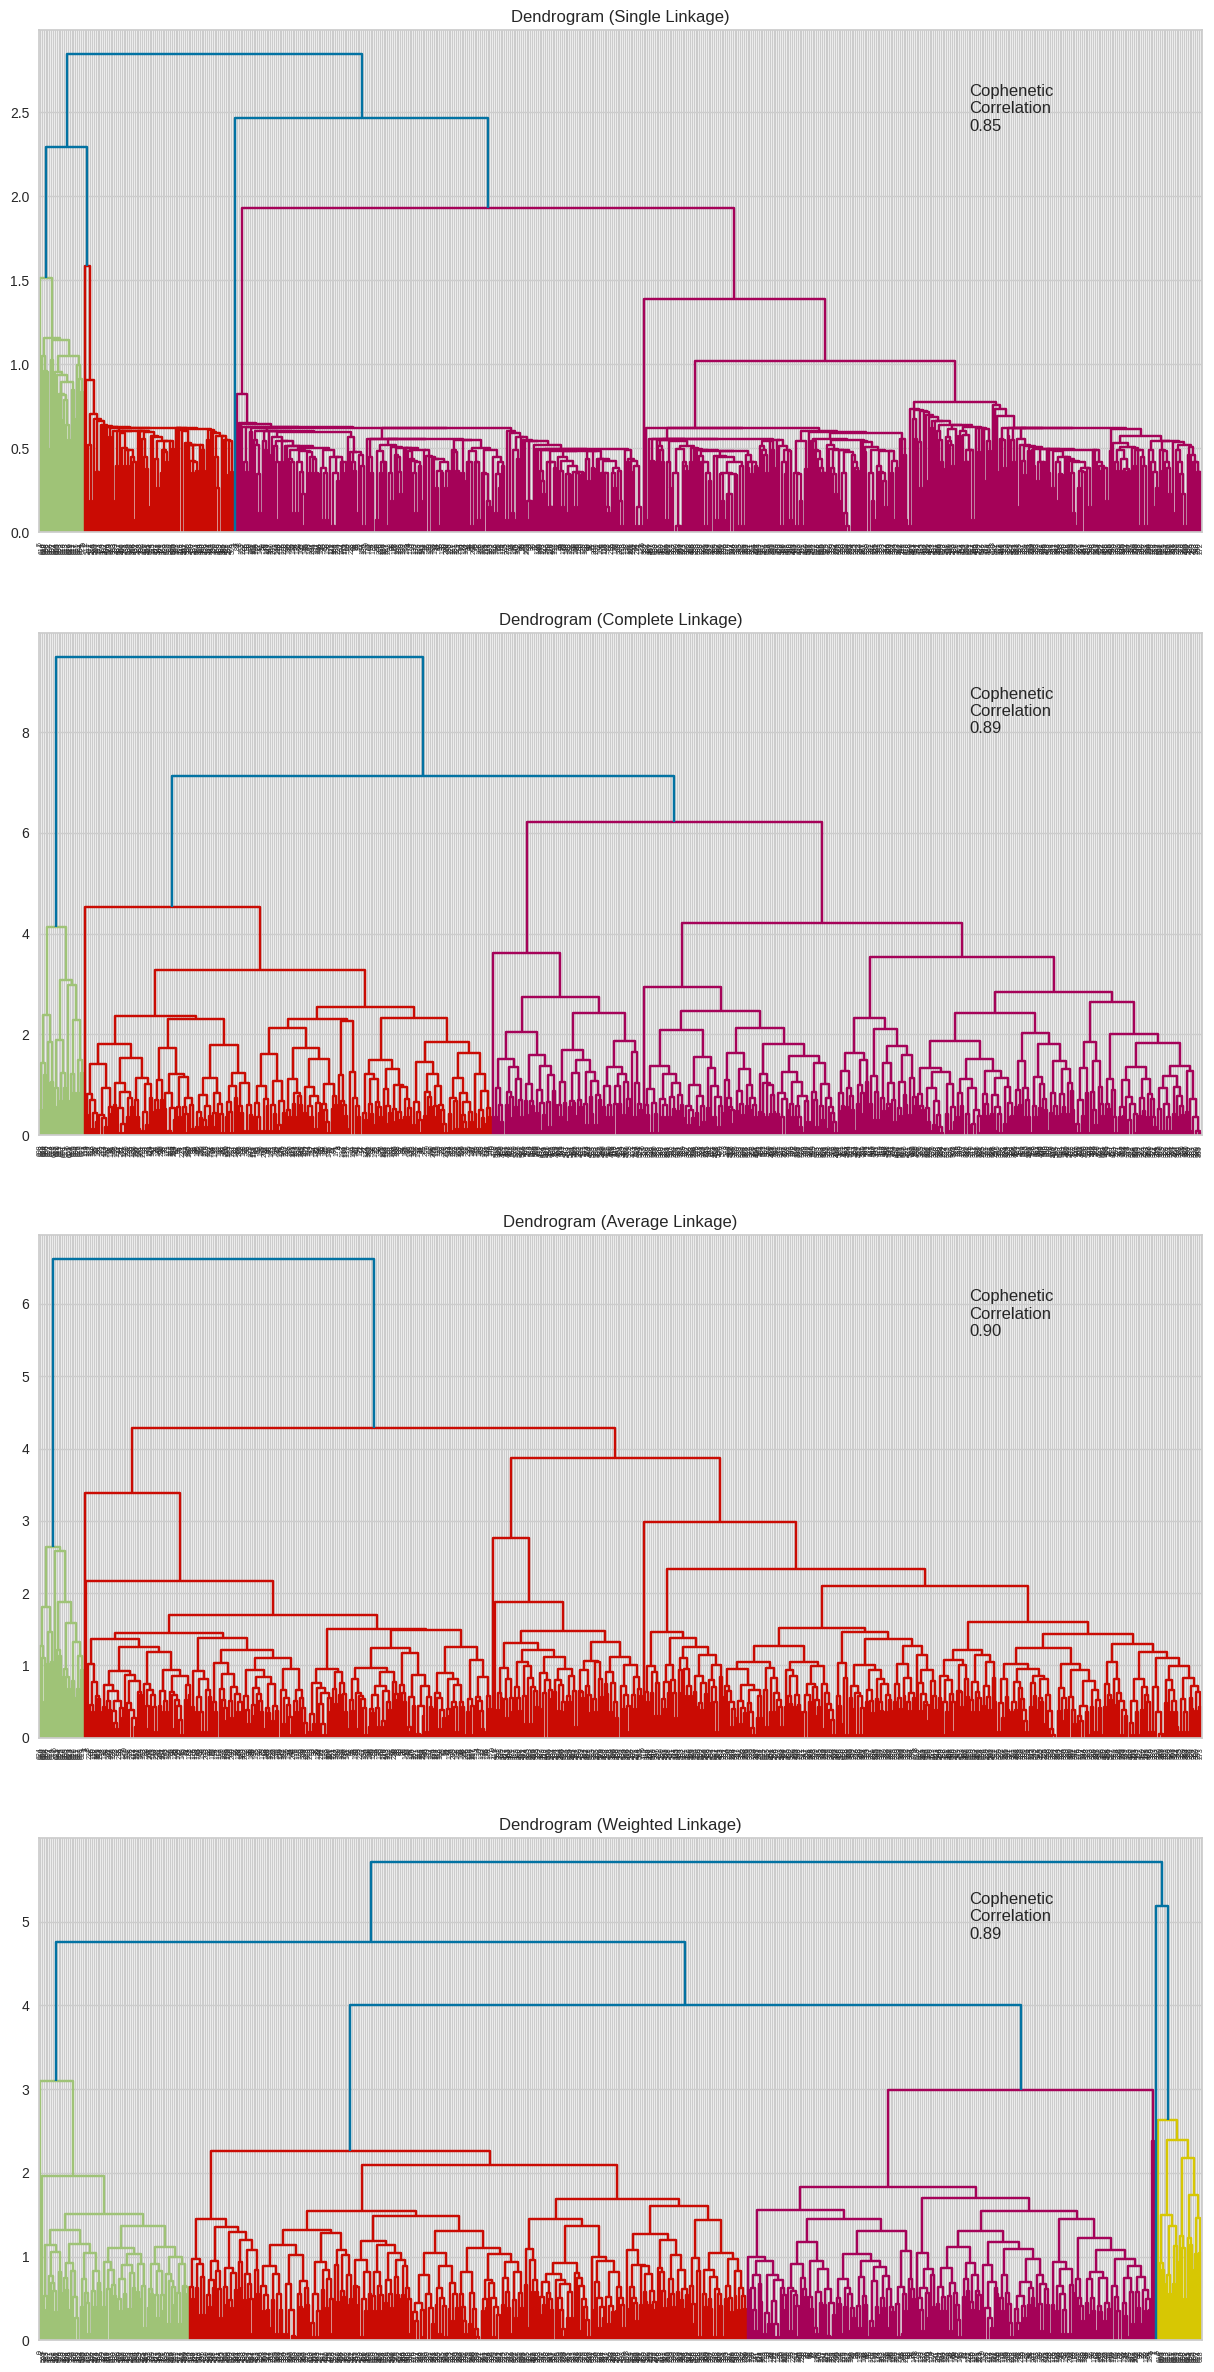

In [ ]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"] ## Complete the code to add linkages

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(dfH, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(dfH))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

In [ ]:
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc = df_cc.sort_values(by="Cophenetic Coefficient")
df_cc

,Linkage,Cophenetic Coefficient
0,single,0.845103
1,complete,0.889994
3,weighted,0.893015
2,average,0.903504


In [ ]:
HCmodel = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='average')  ## Complete the code to define the hierarchical clustering model
HCmodel.fit(dfH)

AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=4)

In [ ]:
# creating a copy of the original data
dfFin = df.copy()

# adding hierarchical cluster labels to the original and scaled dataframes
dfH["HC_segments"] = HCmodel.labels_
dfFin["HC_segments"] = HCmodel.labels_

In [ ]:
dfH.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP,K_means_segments,HC_segments
0,2.696998,-1.239475,-0.914834,-0.535400,-1.293145,4,0,1
1,0.797533,-0.752094,-1.535295,3.244606,1.856695,0,1,0
2,0.797533,1.197433,-0.914834,0.304601,0.106784,4,0,1
3,0.037747,0.222670,-0.914834,-0.535400,0.106784,2,2,2
4,-0.342147,-0.752094,-1.535295,-0.535400,1.506713,0,1,0


In [ ]:
dfFin.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP,HC_segments
0,100000,2,1,1,0,3,1
1,50000,3,0,10,9,2,0
2,50000,7,1,3,4,3,1
3,30000,5,1,1,4,0,2
5,20000,3,0,1,8,2,0


In [ ]:
ScaledDf["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

## Cluster Profiling and Comparison

In [ ]:
km_cluster_profile = dfK.groupby("K_means_segments").mean()  ## Complete the code to groupby the cluster labels

In [ ]:
km_cluster_profile["count_in_each_segment"] = (
    dfK.groupby("K_means_segments")["Avg_Credit_Limit"].count().values  ## Complete the code to groupby the cluster labels
)

In [ ]:
print(km_cluster_profile)

                  Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
K_means_segments                                                            
0                     71142.857143            6.295238           2.066667   
1                     12190.909091            2.395455           0.936364   
2                     26598.006645            5.501661           3.740864   

                  Total_visits_online  Total_calls_made     GROUP  \
K_means_segments                                                    
0                            3.161905          1.923810  3.771429   
1                            3.586364          6.890909  0.000000   
2                            1.006645          1.976744  1.528239   

                  count_in_each_segment  
K_means_segments                         
0                                   105  
1                                   220  
2                                   301  


In [ ]:
hc_cluster_profile = dfH.groupby("HC_segments").mean()

In [ ]:
hc_cluster_profile["count_in_each_segment"] = (
    dfH.groupby("HC_segments")["Avg_Credit_Limit"].count().values
)

In [ ]:
print(hc_cluster_profile)

             Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
HC_segments                                                            
0                   -0.638809           -1.046738          -0.954317   
1                    1.147410            0.469369           0.004368   
2                   -0.091493            0.467170           0.785766   
3                    3.130710            2.151889          -1.121654   

             Total_visits_online  Total_calls_made     GROUP  \
HC_segments                                                    
0                       0.550874          1.118550  0.000000   
1                      -0.576882         -0.541331  4.000000   
2                      -0.532610         -0.601320  1.528239   
3                       3.577106         -0.884833  3.000000   

             K_means_segments  count_in_each_segment  
HC_segments                                           
0                         1.0                    220  
1                

## K-means vs Hierarchical Clustering

You compare several things, like:
- Which clustering technique took less time for execution?
- Which clustering technique gave you more distinct clusters, or are they the same?
- How many observations are there in the similar clusters of both algorithms?
- How many clusters are obtained as the appropriate number of clusters from both algorithms?

You can also mention any differences or similarities you obtained in the cluster profiles from both the clustering techniques.

In [ ]:
#COMPARISONS

## Which clustering technique took less time for execution?
### K-Means clustering took more time and lines to write but the operation for drawing the dendogram varations took the most compute time (39s)

## Which clustering technique gave you more distinct clusters, or are they the same?
### K-Means Clustering did not yield strong distinct silhoutte profiles for me, but indicated 3 potential clusters
### Hierarchical Clustering gave me more distict clusters and was able to help me confirm 4 potential clusters, the additional split being attributed to high-value outliers

## How many observations are there in the similar clusters of both algorithms?
### both groups identified a cluster with 220 customers that prefers phone calls and online banking, and has a low avg credit limit
### both groups identified a cluster with 301 customers that prefers to visit the bank, and has a low number of credit cards

### How many clusters are obtained as the appropriate number of clusters from both algorithms?
### both algorithms indicate that there are at least three distinct clusters


## Actionable Insights and Recommendations

-


In [ ]:
# INSIGHTS AND RECOMMENDATIONS

## Target three segments
### Segment 1: customers that visit the bank in person
### Segment 2: customers that conduct online banking / phone calls
### Segment 3: customers with high avg credit limit ($7K+)

___

In [ ]:
#@title Convert ipynb to HTML in Colab
# Upload ipynb
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")

Saving Copy_of_HC_Full_Code_AIML_USL_Project_CreditCardCustomerSegmentation.ipynb to Copy_of_HC_Full_Code_AIML_USL_Project_CreditCardCustomerSegmentation (1).ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>